In [1]:
# !pip install pmdarima --user

In [2]:
import io
import requests
import pandas as pd
import numpy as np
import OleFileIO_PL
import matplotlib.pyplot as plt
from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.arima_model import ARIMA
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from pylab import rcParams
import pmdarima as pm
from pmdarima.model_selection import train_test_split
from itertools import product
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error
from math import sqrt
import pprint

## Carregamento dos dados

In [3]:
dct = {}
dct['codigo'] = 'soja'

In [4]:
df = pd.read_pickle(f'../dados/cepea-{dct["codigo"]}.p')

In [5]:
# Converte index para data
df.index = pd.to_datetime(df.index, format='%d/%m/%Y')

# Slice para somente o período desejado
df = df['01/01/2007':'01/01/2021']

In [6]:
# Como uma possível sazonalidade nos preços deve ter ciclo anual, com variação mensal, 
# faremos o resample da série para a média de cada mês
df_mes = df.resample('MS').mean()
df.isnull().any()

preco_real     False
preco_dolar    False
dtype: bool

---

# <center>Desenvolvimento de Modelos Preditivos</center>

## MODELOS ARIMA

**Serão gerados 3 modelos:**

**1)** Com um *resample* dos dados para periodicidade mensal, faremos uma projeção pontual, ao fim do dataset de treino, para todo o dataframe de teste. Criaremos:  
    ... **1.1)** Um modelo com a ordem pdq do ARIMA definido via força bruta pelo melhor AIC (Critério de Informação de Akaike) e;   
    ... **1.2)** Outro, com a melhor ordem do Arima estimada pelo Auto-ARIMA.  
    
(Ambos serão confrontados via estatística de erro absoluto médio MAE.)  
  
**2)** Com os dados originais, periodicidade diária, faremos a projeção "dia a dia" do dataframe de test (janela móvel), com o Auto ARIMA (ordem automática)

In [7]:
# Gera train e test sets

# Primeiro, faremos os modelos na periodicidade mensal (para a projeção pontual ao final do período de treino)
sep = df_mes.index.year >= 2019
train = df_mes.preco_dolar[~sep]
test = df_mes.preco_dolar[sep]

# Depois, o modelo diário
sep_oa = df.index.year >= 2020
sep_om = df.index.month > 6
train_o = df.preco_dolar[~(sep_oa & sep_om)]
test_o = df.preco_dolar[sep_oa & sep_om]

mae = {}

#### Brute Force AIC

In [8]:
# Busca pela melhor ordem do modelo ARIMA conforme Critério de Informação de Akaike
# Quanto menor a perda de informação, teoricamente, melhor

pdq = []
akaike = []

# Aplica o modelo ARIMA para todas as combinações de pdq que recebe
def objfunc(order, exog):
    fit = ARIMA(exog, order=order).fit()
    return fit.aic    

# Gera todas as "combinações" de pdq de 000 a 222 e roda o modelo para todas
for order in product(range(3), repeat=3):
    akaike.append(objfunc(order, train))
    pdq.append(order)

C:\Users\conta\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\conta\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


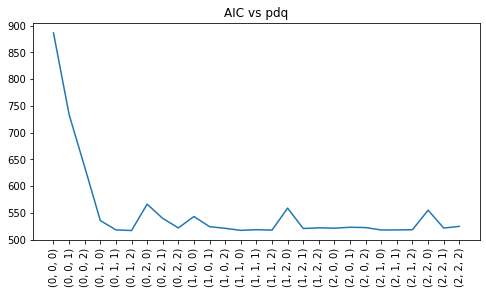

In [9]:
# Plota AIC conforme as ordens do modelo ARIMA
plt.figure(figsize=(8,4))
plt.title('AIC vs pdq')
plt.plot(akaike)
plt.xticks(np.arange(len(akaike)), pdq)
plt.xticks(rotation=90)
plt.show()

In [10]:
# AIC para cada order de ARIMA
# dict(zip(pdq,akaike))

In [11]:
# MELHOR MODELO SEGUNDO CRITÉRIO DE INFORMAÇÃO DE AKAIKE
# Priorizando a primeira ocorrência de baixo indicador - menor ordem - em caso de pequena vantagem de ordens maiores
func = np.vectorize(lambda x: 0 if (abs(x) < 10) else x)
trans_akaike = func(np.diff(akaike).astype(int))
best_aic = pdq[(np.argmax(trans_akaike == 0))]
best_aic # Se uma ordem superior tiver apenas pouca vantagem, será ignorada

(0, 1, 1)

In [12]:
# Funções geradoras de gráficos

# Plot Previsto vs. real
def prev_real(ref, tr, tt, forecast):
    x = ref.index
    plt.title('Previsões (verde) vs. Valores reais (vermelho)')
    plt.plot(x[:tr.size], tr, c='blue')
    plt.plot(x[tr.size:], tt, c='red')
    plt.plot(x[tr.size:], forecast, c='green')
    plt.show()
    
# Plot de resíduos
def show_resid(m):
    # Análise dos resíduos
    residuals = pd.DataFrame(m)
    rcParams['figure.figsize'] = 8, 4
    residuals.plot()
    plt.title('Gráfico de linha dos resíduos')
    plt.show()
    # kde dos resíduos
    residuals.plot(kind='kde')
    plt.title('Distribuição dos resíduos')
    plt.show()
    # resumo dos resíduos
    print(residuals.describe())

                               SARIMAX Results                                
Dep. Variable:            preco_dolar   No. Observations:                  144
Model:                 ARIMA(0, 1, 1)   Log Likelihood                -257.116
Date:                Mon, 11 Jan 2021   AIC                            518.233
Time:                        13:25:10   BIC                            524.158
Sample:                    01-01-2007   HQIC                           520.641
                         - 12-01-2018                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.3390      0.086      3.944      0.000       0.170       0.507
sigma2         2.1325      0.163     13.094      0.000       1.813       2.452
Ljung-Box (L1) (Q):                   0.31   Jarque-

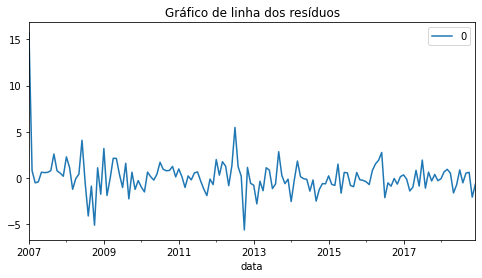

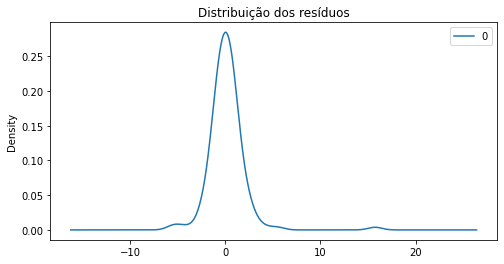

                0
count  144.000000
mean     0.135000
std      1.961824
min     -5.584994
25%     -0.728603
50%     -0.043100
75%      0.803819
max     15.747273


In [13]:
# Treina o modelo com a melhor ordem do ARIMA, segundo critério AIC, escolhido via "força bruta"
model = ARIMA(train, order=best_aic)
model_fit = model.fit()

# Gera forecasts - para períodos out-of-sample (não treinados)
# Se fosse no período treinado, usaríamos predict
aic_forecasts = model_fit.forecast(test.size)

# Sumário do modelo
print(model_fit.summary())

# Mostra gráficos
show_resid(model_fit.resid)

# Salva estatística de erro
mae['aic_brute'] = {}
mae['aic_brute']['order'] = best_aic
mae['aic_brute']['mae'] = mean_absolute_error(test, aic_forecasts)

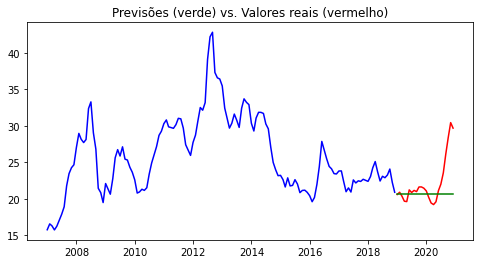

In [14]:
prev_real(df_mes, train, test, aic_forecasts)

#### Auto ARIMA

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  144
Model:               SARIMAX(2, 0, 0)   Log Likelihood                -256.715
Date:                Mon, 11 Jan 2021   AIC                            521.430
Time:                        13:25:27   BIC                            533.309
Sample:                             0   HQIC                           526.257
                                - 144                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      1.4377      0.467      3.081      0.002       0.523       2.352
ar.L1          1.3361      0.074     18.020      0.000       1.191       1.481
ar.L2         -0.3939      0.075     -5.222      0.0

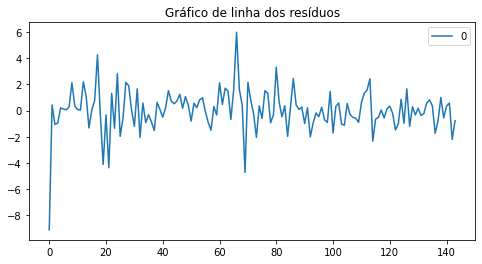

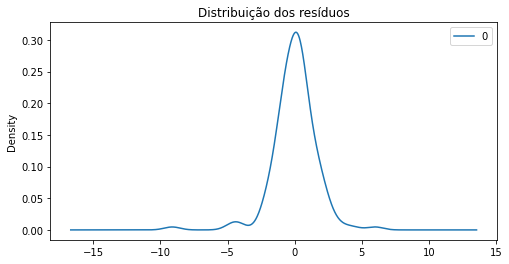

                0
count  144.000000
mean     0.013014
std      1.608019
min     -9.121639
25%     -0.771018
50%      0.121059
75%      0.722498
max      5.986285


In [15]:
# Gera Auto ARIMA
# Por padrão da biblioteca, o critério de informação é o AIC (também)
# e o teste de estacionariedade é o KPSS.
model = pm.auto_arima(train, seasonal=True, m=12) # Adicionamos sazonalidade=12
print(model.summary())

# Gera Previsões
auto_forecasts = model.predict(test.shape[0])

show_resid(model.resid())

# Salva estatística de erro
mae['auto_arima'] = {}
mae['auto_arima']['order'] = model.order
mae['auto_arima']['mae'] = mean_absolute_error(test, auto_forecasts)

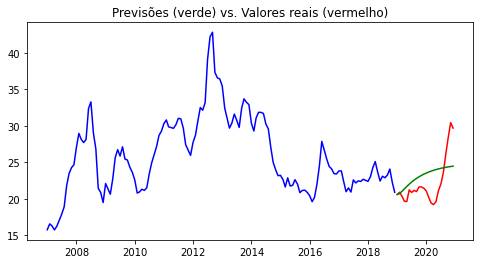

In [16]:
# Mostra previsões (azul=train, vermelho=test, verde=forecasts)
prev_real(df_mes, train, test, auto_forecasts)

In [17]:
# Estatísticas de erro

menor_mae = np.inf

for k, c in mae.items():
    if c['mae'] < menor_mae:
        menor_mae = c['mae']
        melhor_order = c['order']
        melhor_metodo = k

print('Lista de erros:')
pprint.pprint(mae)
print('\n')
print("=" * 50)
print('\n')
[]

print(f'*{melhor_metodo.upper()}* ==> obteve o melhor resultado')
print(f'{melhor_order} ==> foi a ordem pdq')
print(f'{menor_mae} ==> é o erro absoluto médio')
print('\n')
print("=" * 50)

Lista de erros:
{'aic_brute': {'mae': 2.0072796819097367, 'order': (0, 1, 1)},
 'auto_arima': {'mae': 2.3866195180534504, 'order': (2, 0, 0)}}




*AIC_BRUTE* ==> obteve o melhor resultado
(0, 1, 1) ==> foi a ordem pdq
2.0072796819097367 ==> é o erro absoluto médio




### PREVISÃO MÓVEL

Com a série na periodicidade original (diária), faremos uma previsão móvel, em que, a cada passo, é previsto apenas o próximo valor da variável *target*, incluindo o seu valor real e reexecutando os passos, até chegar ao final.

In [18]:
history = [x for x in train_o]
predictions = list()

# Seleciona a melhor ordem do ARIMA, automaticamente
model = pm.auto_arima(history)
order_selected = (1,1,1)

# Loop que caminha ponto a ponto
for t in range(len(test_o)):
    model = ARIMA(history, order=order_selected).fit()
    if t == 0: print(model.summary())
    yhat = model.forecast()[0]
    
    # Gera Previsões
    predictions.append(yhat)
    obs = test_o[t]
    history.append(obs)
    # print('predito=%f, real=%f' % (yhat, obs))

C:\Users\conta\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\conta\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 3366
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -1586.226
Date:                Mon, 11 Jan 2021   AIC                           3178.452
Time:                        13:25:40   BIC                           3196.816
Sample:                             0   HQIC                          3185.019
                               - 3366                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0035      2.328      0.002      0.999      -4.559       4.566
ma.L1          0.0034      2.328      0.001      0.999      -4.559       4.566
sigma2         0.1503      0.001    153.620      0.0

C:\Users\conta\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\conta\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\conta\AppData\Roaming\Python\Python37\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\conta\AppData\Roaming\Python\Python37\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


In [19]:
# Avalia previsões
mae_movel = mean_absolute_error(test_o, predictions)
print('MAE: %.3f' % mae_movel)

MAE: 0.384


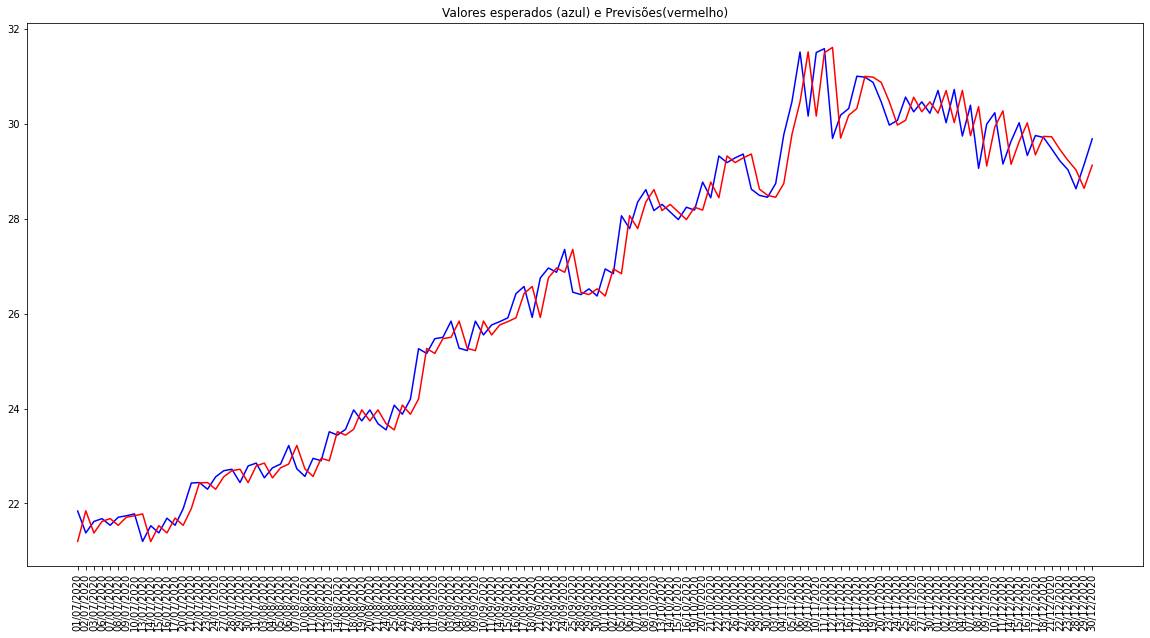

In [20]:
# plot previsões contra valores esperados
rcParams['figure.figsize'] = 20, 10

plt.plot(test_o.values, color='blue')
plt.plot(predictions, color='red' )
plt.title('Valores esperados (azul) e Previsões(vermelho)')
plt.xticks(np.arange(test_o.size),test_o.index.strftime("%d/%m/%Y"))
plt.xticks(rotation=90)
plt.show()

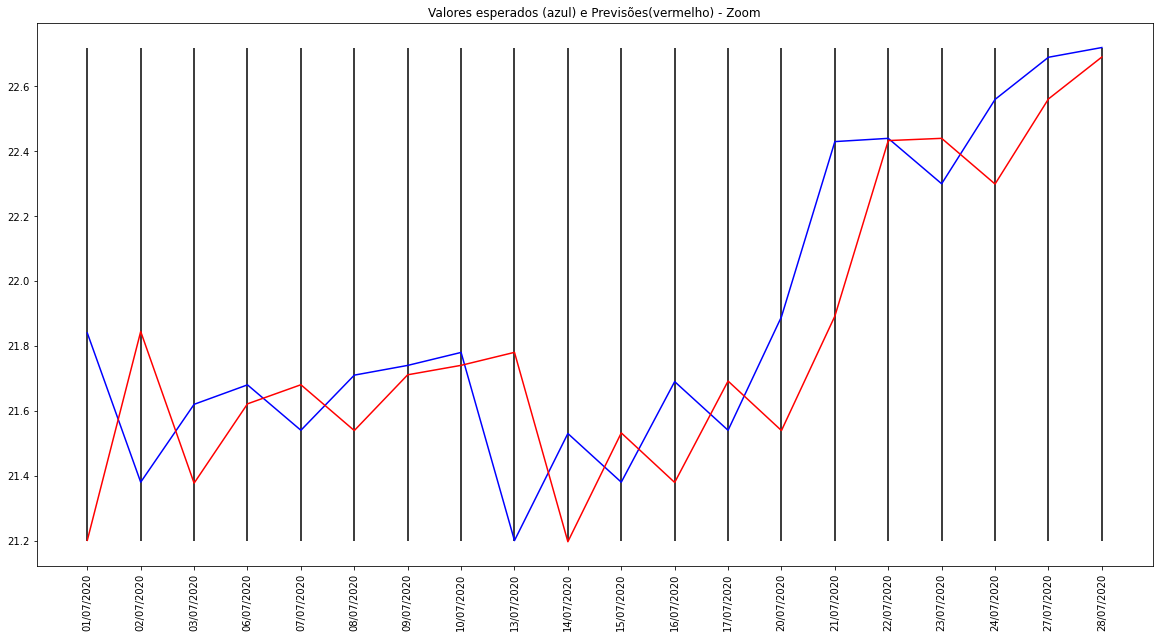

In [21]:
# plot previsões contra valores esperados, com zoom e linhas verticais
limite = slice(20)

plt.plot(test_o.values[limite], color='blue')
plt.plot(predictions[limite], color='red' )
plt.title('Valores esperados (azul) e Previsões(vermelho) - Zoom')
plt.xticks(np.arange(test_o.size),test_o.index.strftime("%d/%m/%Y"))
plt.xticks(rotation=90)
plt.vlines(np.arange(test_o.size)[limite], ymin=min(test_o[limite]), ymax=max(test_o[limite]), colors='k', linestyles='solid')
plt.show()